
# Hmax 模型实现

In [1]:
import numpy as np
from scipy.io import loadmat
import torch
from torch import nn

In [2]:
def gabor_filter(size, wavelength, orientation):
    
    lambda_ = size * 2. / wavelength
    sigma = lambda_ * 0.8
    gamma = 0.3  # spatial aspect ratio: 0.23 < gamma < 0.92
    theta = np.deg2rad(orientation + 90)

    # Generate Gabor filter
    x, y = np.mgrid[:size, :size] - (size // 2)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    filt = np.exp(-(rotx**2 + gamma**2 * roty**2) / (2 * sigma ** 2))
    filt *= np.cos(2 * np.pi * rotx / lambda_)
    filt[np.sqrt(x**2 + y**2) > (size / 2)] = 0

    # Normalize the filter
    filt = filt - np.mean(filt)
    filt = filt / np.sqrt(np.sum(filt ** 2))

    return filt


In [3]:
class S1(nn.Module):
    
    def __init__(self, size, wavelength, orientations=[90, -45, 0, 45]):
        super().__init__()
        self.num_orientations = len(orientations)
        self.size = size

        # Use PyTorch's Conv2d as a base object. Each "channel" will be an
        # orientation.
        self.gabor = nn.Conv2d(1, self.num_orientations, size,
                               padding=size // 2, bias=False)

        # Fill the Conv2d filter weights with Gabor kernels: one for each
        # orientation
        for channel, orientation in enumerate(orientations):
            self.gabor.weight.data[channel, 0] = torch.Tensor(
                gabor_filter(size, wavelength, orientation))

        # A convolution layer filled with ones. This is used to normalize the
        # result in the forward method.
        self.uniform = nn.Conv2d(1, 4, size, padding=size // 2, bias=False)
        nn.init.constant_(self.uniform.weight, 1)

        # Since everything is pre-computed, no gradient is required
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, img):
        """Apply Gabor filters, take absolute value, and normalize."""
        s1_output = torch.abs(self.gabor(img))
        norm = torch.sqrt(self.uniform(img ** 2))
        norm.data[norm == 0] = 1  # To avoid divide by zero
        s1_output /= norm
        return s1_output


In [4]:
class C1(nn.Module):
    
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.local_pool = nn.MaxPool2d(size, stride=size // 2,
                                       padding=size // 2)

    def forward(self, s1_outputs):
        """Max over scales, followed by a MaxPool2d operation."""
        s1_outputs = torch.cat([out.unsqueeze(0) for out in s1_outputs], 0)

        # Pool over all scales
        s1_output, _ = torch.max(s1_outputs, dim=0)

        # Pool over local (c1_space x c1_space) neighbourhood
        return self.local_pool(s1_output)


In [5]:
class S2(nn.Module):
    
    def __init__(self, patches, activation='gaussian', sigma=1):
        super().__init__()
        self.activation = activation
        self.sigma = sigma

        num_patches, num_orientations, size, _ = patches.shape

        # Main convolution layer
        self.conv = nn.Conv2d(in_channels=num_orientations,
                              out_channels=num_orientations * num_patches,
                              kernel_size=size,
                              padding=size // 2,
                              groups=num_orientations,
                              bias=False)
        self.conv.weight.data = torch.Tensor(
            patches.transpose(1, 0, 2, 3).reshape(1600, 1, size, size))

        # A convolution layer filled with ones. This is used for the distance
        # computation
        self.uniform = nn.Conv2d(1, 1, size, padding=size // 2, bias=False)
        nn.init.constant_(self.uniform.weight, 1)

        # This is also used for the distance computation
        self.patches_sum_sq = nn.Parameter(
            torch.Tensor((patches ** 2).sum(axis=(1, 2, 3))))

        self.num_patches = num_patches
        self.num_orientations = num_orientations
        self.size = size

        # No gradient required for this layer
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, c1_outputs):
        s2_outputs = []
        for c1_output in c1_outputs:
            conv_output = self.conv(c1_output)

            # Unstack the orientations
            conv_output_size = conv_output.shape[3]
            conv_output = conv_output.view(
                -1, self.num_orientations, self.num_patches, conv_output_size,
                conv_output_size)

            # Pool over orientations
            conv_output = conv_output.sum(dim=1)

            # Compute distance
            c1_sq = self.uniform(
                torch.sum(c1_output ** 2, dim=1, keepdim=True))
            dist = c1_sq - 2 * conv_output
            dist += self.patches_sum_sq[None, :, None, None]

            # Apply activation function
            if self.activation == 'gaussian':
                dist = torch.exp(- 1 / (2 * self.sigma ** 2) * dist)
            elif self.activation == 'euclidean':
                dist[dist < 0] = 0  # Negative values should never occur
                torch.sqrt_(dist)
                dist = -dist
            else:
                raise ValueError("activation parameter should be either "
                                 "'gaussian' or 'euclidean'.")

            s2_outputs.append(dist)
        return s2_outputs


In [6]:
class C2(nn.Module):
    """A layer of C2 units operating on a layer of S2 units."""
    def forward(self, s2_outputs):
        """Take the maximum value of the underlying S2 units."""
        maxs = [s2.max(dim=3)[0] for s2 in s2_outputs]
        maxs = [m.max(dim=2)[0] for m in maxs]
        maxs = torch.cat([m[:, None, :] for m in maxs], 1)
        return maxs.max(dim=1)[0]


In [99]:
class HMAX(nn.Module):
    
    def __init__(self, universal_patch_set, s2_act='gaussian'):
        super().__init__()

        # S1 layers, consisting of units with increasing size
        self.s1_units = [
            S1(size=7, wavelength=4),
            S1(size=9, wavelength=3.95),
            S1(size=11, wavelength=3.9),
            S1(size=13, wavelength=3.85),
            S1(size=15, wavelength=3.8),
            S1(size=17, wavelength=3.75),
            S1(size=19, wavelength=3.7),
            S1(size=21, wavelength=3.65),
            S1(size=23, wavelength=3.6),
            S1(size=25, wavelength=3.55),
            S1(size=27, wavelength=3.5),
            S1(size=29, wavelength=3.45),
            S1(size=31, wavelength=3.4),
            S1(size=33, wavelength=3.35),
            S1(size=35, wavelength=3.3),
            S1(size=37, wavelength=3.25),
        ]

        # Explicitly add the S1 units as submodules of the model
        for s1 in self.s1_units:
            self.add_module('s1_%02d' % s1.size, s1)

        # Each C1 layer pools across two S1 layers
        self.c1_units = [
            C1(size=8),
            C1(size=10),
            C1(size=12),
            C1(size=14),
            C1(size=16),
            C1(size=18),
            C1(size=20),
            C1(size=22),
        ]

        # Explicitly add the C1 units as submodules of the model
        for c1 in self.c1_units:
            self.add_module('c1_%02d' % c1.size, c1)

        # Read the universal patch set for the S2 layer
        m = loadmat(universal_patch_set)
        patches = [patch.reshape(shape[[2, 1, 0, 3]]).transpose(3, 0, 2, 1)
                   for patch, shape in zip(m['patches'][0], m['patchSizes'].T)]

        # One S2 layer for each patch scale, operating on all C1 layers
        self.s2_units = [S2(patches=scale_patches, activation=s2_act)
                         for scale_patches in patches]

        # Explicitly add the S2 units as submodules of the model
        for i, s2 in enumerate(self.s2_units):
            self.add_module('s2_%d' % i, s2)

        # One C2 layer operating on each scale
        self.c2_units = [C2() for s2 in self.s2_units]

        # Explicitly add the C2 units as submodules of the model
        for i, c2 in enumerate(self.c2_units):
            self.add_module('c2_%d' % i, c2)
        
    
    def run_all_layers(self, img):
        
        s1_outputs = [s1(img) for s1 in self.s1_units]

        # Each C1 layer pools across two S1 layers
        c1_outputs = []
        for c1, i in zip(self.c1_units, range(0, len(self.s1_units), 2)):
            c1_outputs.append(c1(s1_outputs[i:i+2]))

        s2_outputs = [s2(c1_outputs) for s2 in self.s2_units]
        c2_outputs = [c2(s2) for c2, s2 in zip(self.c2_units, s2_outputs)]

        return s1_outputs, c1_outputs, s2_outputs, c2_outputs

    def forward(self, img):
        """Run through everything and concatenate the output of the C2s."""
        c2_outputs = self.run_all_layers(img)[-1]
        c2_outputs = torch.cat(
            c2_outputs, 1)
        
        return c2_outputs

    def get_all_layers(self, img):
        
        s1_out, c1_out, s2_out, c2_out = self.run_all_layers(img)


        return (
            [s1.cpu().detach().numpy() for s1 in s1_out],
            [c1.cpu().detach().numpy() for c1 in c1_out],
            [[s2_.cpu().detach().numpy() for s2_ in s2] for s2 in s2_out],
            [c2.cpu().detach().numpy() for c2 in c2_out],
        )


## 分类器模型

In [100]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                nn.Linear(400 * 8,1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024,128),
                nn.ReLU(inplace=True),
                nn.Linear(128,10))
    def forward(self, feature):
        x = self.fc(feature)
        return x

## 数据集的构造以及模型训练

In [101]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle
import torchvision.datasets as dsets

from torch import  optim

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
# MNIST dataset

In [107]:
# hyper parameter
input_size = 28 * 28 # image size of MNIST data
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 5e-3

In [103]:

train_dataset = dsets.MNIST(root = '../data_sets/mnist', #选择数据的根目录
                           train = True, # 选择训练集
                           transform = transforms.ToTensor(), #转换成tensor变量
                           download = True) # 不从网络上download图片
test_dataset = dsets.MNIST(root = '../data_sets/mnist', #选择数据的根目录
                           train = False, # 选择训练集
                           transform = transforms.ToTensor(), #转换成tensor变量
                           download = True) # 不从网络上download图片
#加载数据

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle = True)  # 将数据打乱
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

In [104]:
# Initialize the model with the universal patch set
print('Constructing model')
model = HMAX('./universal_patch_set.mat')
net = MLP()

Constructing model


In [105]:
# Determine whether there is a compatible GPU available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Running model on', device)
model = model.to(device)
net = net.to(device)

Running model on cuda:0


In [15]:
train_data = []
test_data = []

for data in tqdm(train_loader):
        img , label = data
        img = img.to(device)
        label = label.to(device)
        feature = model(img)## 使用Hmax提取特征
        train_data.append((feature.detach().cpu(),label.cpu()))
        
        ## 使用hmax 特征保存特征图
        
for data in tqdm(test_loader):
        img , label = data
        img = img.to(device)
        label = label.to(device)
        feature = model(img)## 使用Hmax提取特征
        
        test_data.append((feature.detach().cpu(),label.cpu()))
        
        ## 使用hmax 特征保存特征图



100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [23]:
torch.save(train_data,"mnist_feature_train")
torch.save(test_data,"mnist_feature_test")

## 训练

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=learning_rate,weight_decay=0.0)
 
# 开始训练
losses =[]
acces = []
eval_losses = []
eval_acces = []
 
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    net = net.train()

    for data in tqdm(train_data):
        count+=1
        feature , label = data
        #img = img.reshape(img.size(0),-1) 
        feature = feature.to(device)
        label = label.to(device)
        
        
        
        
        # 前向传播
        out = net(feature)
        loss = criterion(out,label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
       
        train_acc += acc
        
        print_loss += loss.item()
        print_acc += acc
        
        
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    
    eval_loss = 0
    eval_acc = 0
    # 测试集不训练
    for feature , label in test_data:
        #img = img.reshape(img.size(0),-1)
        feature = feature.to(device)
        label = label.to(device)
        
    
        out = net(feature)
        
        loss = criterion(out,label)
        
        # 记录误差
        eval_loss += loss.item()
        
        _ , pred = out.max(1)
        num_correct = (pred==label).sum().item()
        acc = num_correct / img.shape[0]
        
        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    
    print('Epoch {} Train Loss {} Train  Accuracy {} Teat Loss {} Test Accuracy {}'.format(
        epoch+1, train_loss / len(train_data),train_acc / len(train_data), eval_loss / len(test_data), eval_acc / len(test_data)))

  4%|▍         | 24/600 [00:00<00:02, 239.88it/s]

Epoch 1 Train Loss 1.498735032081604 Train  Accuracy 45.678333333333335 Teat Loss 0.9463381266593933 Test Accuracy 67.56


  4%|▍         | 24/600 [00:00<00:02, 237.45it/s]

Epoch 2 Train Loss 0.9169951442877452 Train  Accuracy 68.38833333333334 Teat Loss 0.7413402897119522 Test Accuracy 74.72


  4%|▍         | 25/600 [00:00<00:02, 245.46it/s]

Epoch 3 Train Loss 0.7647651771704356 Train  Accuracy 73.80166666666666 Teat Loss 0.6667153894901275 Test Accuracy 77.16


  4%|▍         | 25/600 [00:00<00:02, 242.29it/s]

Epoch 4 Train Loss 0.6443643061816693 Train  Accuracy 78.29333333333334 Teat Loss 0.6146594119071961 Test Accuracy 78.27


  4%|▍         | 24/600 [00:00<00:02, 239.31it/s]

Epoch 5 Train Loss 0.5652555092175802 Train  Accuracy 80.96833333333333 Teat Loss 0.6033122229576111 Test Accuracy 78.69


  4%|▍         | 24/600 [00:00<00:02, 237.32it/s]

Epoch 6 Train Loss 0.5055594098567963 Train  Accuracy 83.04333333333334 Teat Loss 0.6851694384217262 Test Accuracy 76.58


  4%|▍         | 26/600 [00:00<00:02, 255.19it/s]

Epoch 7 Train Loss 0.4664510783056418 Train  Accuracy 84.46 Teat Loss 0.7039351406693458 Test Accuracy 75.83


  4%|▍         | 24/600 [00:00<00:02, 238.05it/s]

Epoch 8 Train Loss 0.4373295883337657 Train  Accuracy 85.6 Teat Loss 0.4885593903064728 Test Accuracy 83.12


  4%|▍         | 25/600 [00:00<00:02, 241.24it/s]

Epoch 9 Train Loss 0.42151697039604186 Train  Accuracy 86.11 Teat Loss 0.3451214063167572 Test Accuracy 88.43


  4%|▍         | 25/600 [00:00<00:02, 240.96it/s]

Epoch 10 Train Loss 0.3941610439121723 Train  Accuracy 86.97833333333334 Teat Loss 0.35305031672120096 Test Accuracy 88.61


  4%|▍         | 24/600 [00:00<00:02, 236.05it/s]

Epoch 11 Train Loss 0.3964399578422308 Train  Accuracy 86.925 Teat Loss 0.3025267778337002 Test Accuracy 90.38


  4%|▍         | 24/600 [00:00<00:02, 236.01it/s]

Epoch 12 Train Loss 0.36595016101996103 Train  Accuracy 87.84833333333333 Teat Loss 0.3185642571747303 Test Accuracy 89.41


  4%|▍         | 25/600 [00:00<00:02, 245.65it/s]

Epoch 13 Train Loss 0.36790969206641116 Train  Accuracy 87.94833333333334 Teat Loss 0.36329686105251313 Test Accuracy 87.64


  4%|▍         | 24/600 [00:00<00:02, 237.79it/s]

Epoch 14 Train Loss 0.3467675281067689 Train  Accuracy 88.56833333333333 Teat Loss 0.27537810400128365 Test Accuracy 91.35


  4%|▍         | 24/600 [00:00<00:02, 238.06it/s]

Epoch 15 Train Loss 0.3544896749779582 Train  Accuracy 88.49333333333334 Teat Loss 0.3172769144177437 Test Accuracy 89.81


  4%|▍         | 24/600 [00:00<00:02, 239.47it/s]

Epoch 16 Train Loss 0.34651498327652613 Train  Accuracy 88.57166666666667 Teat Loss 0.2976908621191978 Test Accuracy 90.41


  4%|▍         | 24/600 [00:00<00:02, 239.67it/s]

Epoch 17 Train Loss 0.3220398757730921 Train  Accuracy 89.35333333333334 Teat Loss 0.30229913502931594 Test Accuracy 90.0


  4%|▍         | 25/600 [00:00<00:02, 248.03it/s]

Epoch 18 Train Loss 0.32252446324874956 Train  Accuracy 89.51 Teat Loss 0.2805065993964672 Test Accuracy 90.73


  4%|▍         | 24/600 [00:00<00:02, 237.57it/s]

Epoch 19 Train Loss 0.32622561911741893 Train  Accuracy 89.30333333333333 Teat Loss 0.280652374625206 Test Accuracy 90.57


  4%|▍         | 24/600 [00:00<00:02, 236.78it/s]

Epoch 20 Train Loss 0.30799831842382747 Train  Accuracy 89.92666666666666 Teat Loss 0.2572685642540455 Test Accuracy 91.74


  4%|▍         | 25/600 [00:00<00:02, 245.16it/s]

Epoch 21 Train Loss 0.3060401362925768 Train  Accuracy 89.90166666666667 Teat Loss 0.23715648643672466 Test Accuracy 92.3


  4%|▍         | 24/600 [00:00<00:02, 237.21it/s]

Epoch 22 Train Loss 0.2994966040924191 Train  Accuracy 90.28166666666667 Teat Loss 0.23274467088282108 Test Accuracy 92.52


  4%|▍         | 24/600 [00:00<00:02, 237.50it/s]

Epoch 23 Train Loss 0.30614841837435963 Train  Accuracy 89.98666666666666 Teat Loss 0.23652093626558782 Test Accuracy 92.52


  4%|▍         | 24/600 [00:00<00:02, 236.76it/s]

Epoch 24 Train Loss 0.2967244022960464 Train  Accuracy 90.35666666666667 Teat Loss 0.21491165459156036 Test Accuracy 93.18


  4%|▍         | 24/600 [00:00<00:02, 238.54it/s]

Epoch 25 Train Loss 0.29215435319890576 Train  Accuracy 90.44 Teat Loss 0.23389119498431682 Test Accuracy 92.47


  4%|▍         | 26/600 [00:00<00:02, 250.11it/s]

Epoch 26 Train Loss 0.2925210443387429 Train  Accuracy 90.45333333333333 Teat Loss 0.2779976089298725 Test Accuracy 90.82


  4%|▍         | 24/600 [00:00<00:02, 237.64it/s]

Epoch 27 Train Loss 0.29088407694051666 Train  Accuracy 90.48833333333333 Teat Loss 0.21779065676033496 Test Accuracy 93.36


  4%|▍         | 24/600 [00:00<00:02, 237.79it/s]

Epoch 28 Train Loss 0.28342097798983257 Train  Accuracy 90.72166666666666 Teat Loss 0.1975006728619337 Test Accuracy 93.94


  4%|▍         | 25/600 [00:00<00:02, 244.24it/s]

Epoch 29 Train Loss 0.2704662518575788 Train  Accuracy 91.17166666666667 Teat Loss 0.24223537497222425 Test Accuracy 92.22


  4%|▍         | 24/600 [00:00<00:02, 238.87it/s]

Epoch 30 Train Loss 0.2762731800849239 Train  Accuracy 90.95 Teat Loss 0.1960151618719101 Test Accuracy 93.77


  4%|▍         | 24/600 [00:00<00:02, 239.95it/s]

Epoch 31 Train Loss 0.2659812558318178 Train  Accuracy 91.275 Teat Loss 0.19973665356636047 Test Accuracy 93.57


  4%|▍         | 26/600 [00:00<00:02, 256.05it/s]

Epoch 32 Train Loss 0.2701515846202771 Train  Accuracy 91.03666666666666 Teat Loss 0.23831320963799954 Test Accuracy 92.28


  4%|▍         | 24/600 [00:00<00:02, 238.35it/s]

Epoch 33 Train Loss 0.26072489083434147 Train  Accuracy 91.55166666666666 Teat Loss 0.2139506097882986 Test Accuracy 93.12


  4%|▍         | 26/600 [00:00<00:02, 251.54it/s]

Epoch 34 Train Loss 0.27073895381142693 Train  Accuracy 91.185 Teat Loss 0.19637844525277615 Test Accuracy 93.69


  4%|▍         | 24/600 [00:00<00:02, 237.90it/s]

Epoch 35 Train Loss 0.2573104672009746 Train  Accuracy 91.56833333333333 Teat Loss 0.23666977688670157 Test Accuracy 92.03


  4%|▍         | 25/600 [00:00<00:02, 247.14it/s]

Epoch 36 Train Loss 0.26399054264028865 Train  Accuracy 91.28166666666667 Teat Loss 0.1917084052786231 Test Accuracy 94.0


  4%|▍         | 24/600 [00:00<00:02, 237.30it/s]

Epoch 37 Train Loss 0.25864473221823575 Train  Accuracy 91.51 Teat Loss 0.1900875435769558 Test Accuracy 93.84


  4%|▍         | 24/600 [00:00<00:02, 239.17it/s]

Epoch 38 Train Loss 0.2643392431611816 Train  Accuracy 91.36333333333333 Teat Loss 0.1955696524679661 Test Accuracy 93.76


  4%|▍         | 24/600 [00:00<00:02, 238.95it/s]

Epoch 39 Train Loss 0.2645916025340557 Train  Accuracy 91.44833333333334 Teat Loss 0.1983995671570301 Test Accuracy 93.79


  4%|▍         | 25/600 [00:00<00:02, 244.71it/s]

Epoch 40 Train Loss 0.25004607466359935 Train  Accuracy 91.95666666666666 Teat Loss 0.2003011777997017 Test Accuracy 93.72


  4%|▍         | 25/600 [00:00<00:02, 249.50it/s]

Epoch 41 Train Loss 0.2550393204763532 Train  Accuracy 91.66333333333333 Teat Loss 0.18567119661718606 Test Accuracy 94.2


  4%|▍         | 24/600 [00:00<00:02, 238.91it/s]

Epoch 42 Train Loss 0.25342677656561136 Train  Accuracy 91.82166666666667 Teat Loss 0.22239713616669177 Test Accuracy 93.02


  4%|▍         | 24/600 [00:00<00:02, 236.62it/s]

Epoch 43 Train Loss 0.2501709721982479 Train  Accuracy 91.95 Teat Loss 0.1877922723069787 Test Accuracy 94.02


  4%|▍         | 24/600 [00:00<00:02, 237.35it/s]

Epoch 44 Train Loss 0.24755312457680703 Train  Accuracy 91.98 Teat Loss 0.19886532682925462 Test Accuracy 93.8


  4%|▍         | 24/600 [00:00<00:02, 238.54it/s]

Epoch 45 Train Loss 0.241775946157674 Train  Accuracy 92.23333333333333 Teat Loss 0.1740738519653678 Test Accuracy 94.33


  4%|▍         | 24/600 [00:00<00:02, 238.41it/s]

Epoch 46 Train Loss 0.24479278145978847 Train  Accuracy 92.115 Teat Loss 0.17277373682707547 Test Accuracy 94.54


  4%|▍         | 26/600 [00:00<00:02, 253.95it/s]

Epoch 47 Train Loss 0.23917479505141576 Train  Accuracy 92.31666666666666 Teat Loss 0.20935385145246982 Test Accuracy 93.2


  4%|▍         | 24/600 [00:00<00:02, 236.64it/s]

Epoch 48 Train Loss 0.2353630955889821 Train  Accuracy 92.495 Teat Loss 0.2050686940550804 Test Accuracy 93.51


  4%|▍         | 26/600 [00:00<00:02, 251.46it/s]

Epoch 49 Train Loss 0.2432995875303944 Train  Accuracy 92.18666666666667 Teat Loss 0.2096289847046137 Test Accuracy 93.43


100%|██████████| 600/600 [00:02<00:00, 241.79it/s]


Epoch 50 Train Loss 0.23982421295096476 Train  Accuracy 92.34 Teat Loss 0.24328192435204982 Test Accuracy 92.22


### 训练数据可视化

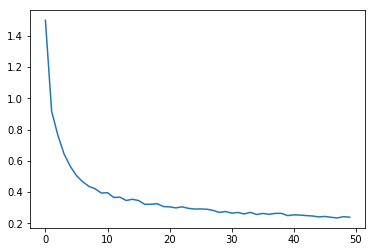

In [108]:
x = np.arange(0,len(losses),1)
plt.plot(x,losses,"-")

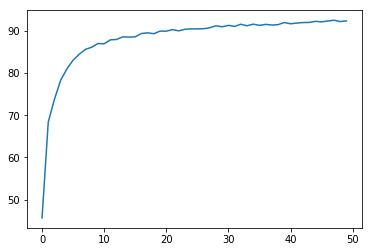

In [109]:
x = np.arange(0,len(acces),1)
plt.plot(x,acces,"-")

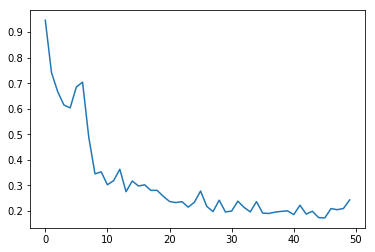

In [110]:
x = np.arange(0,len(eval_losses),1)
plt.plot(x,eval_losses,"-")

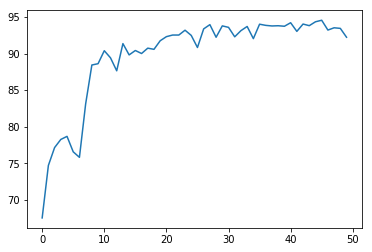

In [111]:
x = np.arange(0,len(eval_acces),1)
plt.plot(x,eval_acces,"-")

### Feature 构建可视化

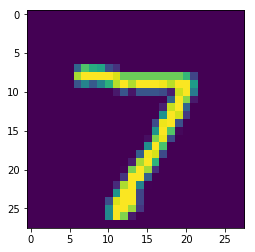

In [112]:
img,label = test_dataset[0]
plt.imshow(img.view(28,28))

In [113]:
img = img.view(1,1,28,28).to(device)

s1, c1, s2, c2 = model.get_all_layers(img)

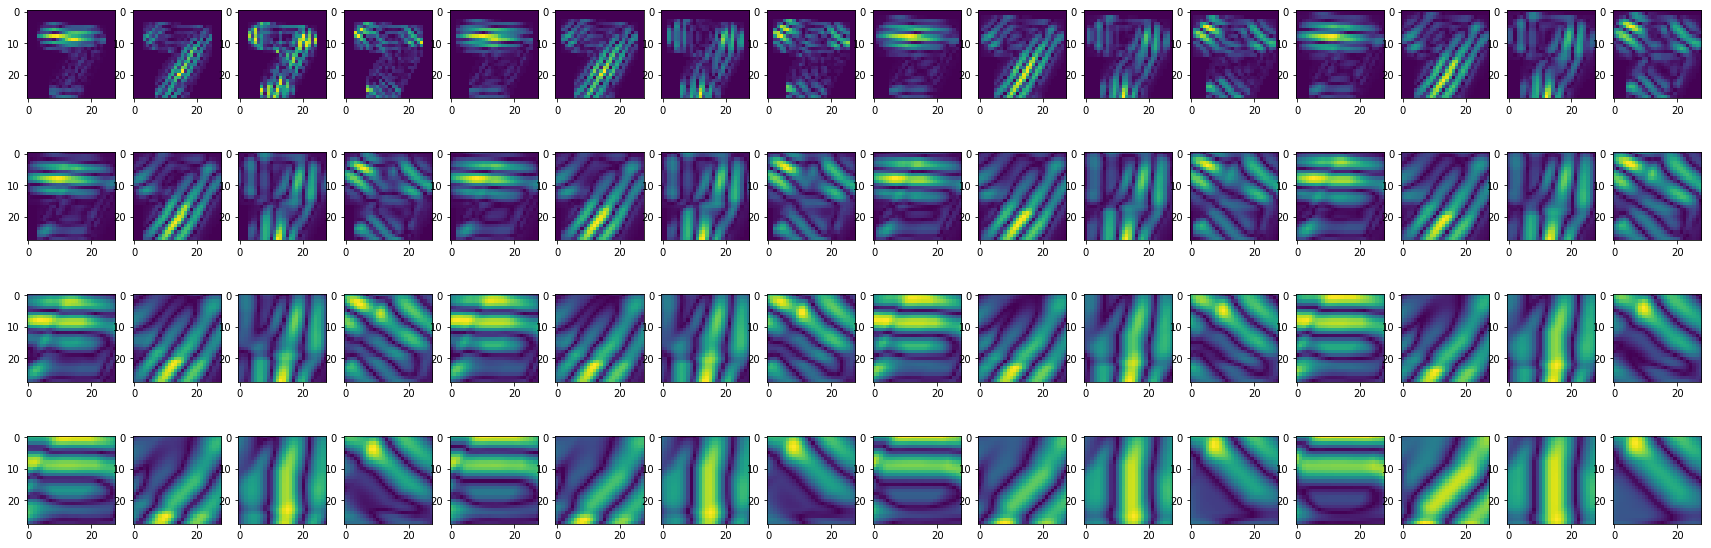

In [114]:
fig = plt.figure(figsize=(30, 10))
for i in range(16):
    for j in range(4):
        si = s1[i][0,j,:,:]
        ax = fig.add_subplot(4,16,i*4+j+1)
        ax.imshow(si.reshape(28,28))
plt.savefig("1.jpg")
plt.show()

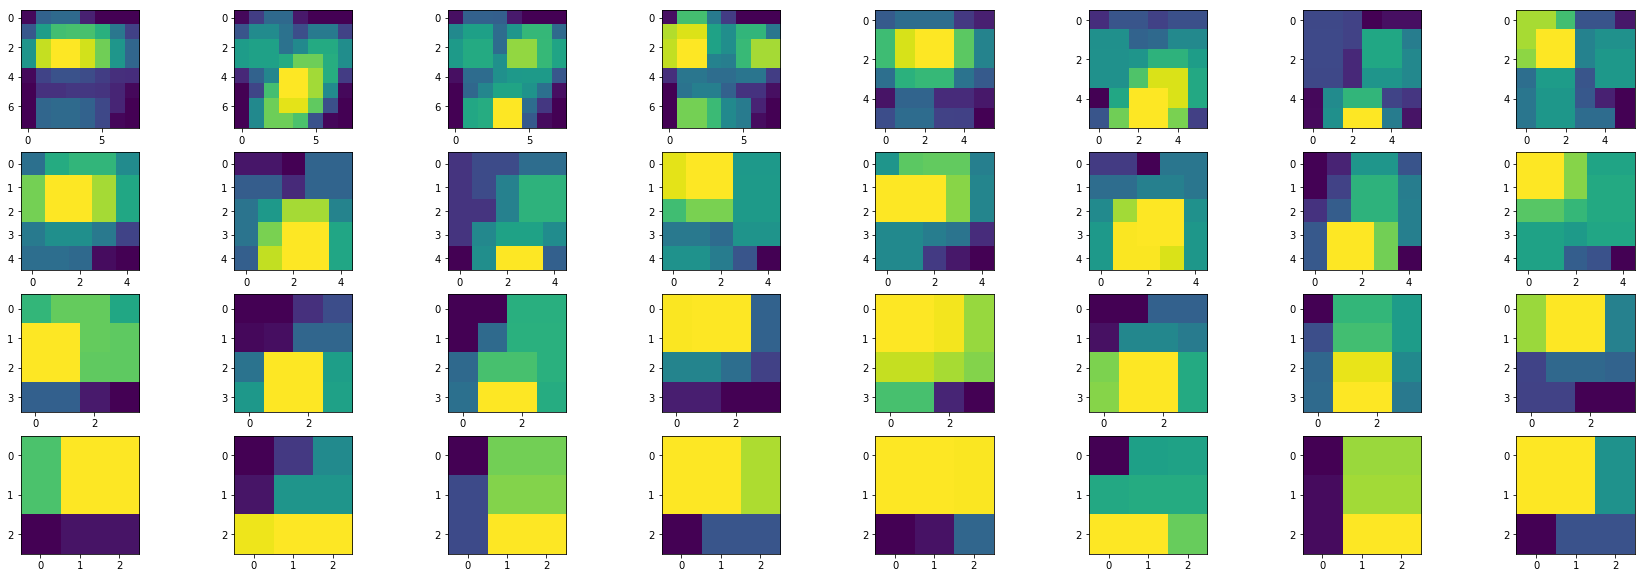

In [115]:
fig = plt.figure(figsize=(30, 10))
for i in range(8):
    for j in range(4):
        ci = c1[i][0,j,:,:]
        ax = fig.add_subplot(4,8,i*4+j+1)
        ax.imshow(ci)
plt.savefig("2.jpg")
plt.show()

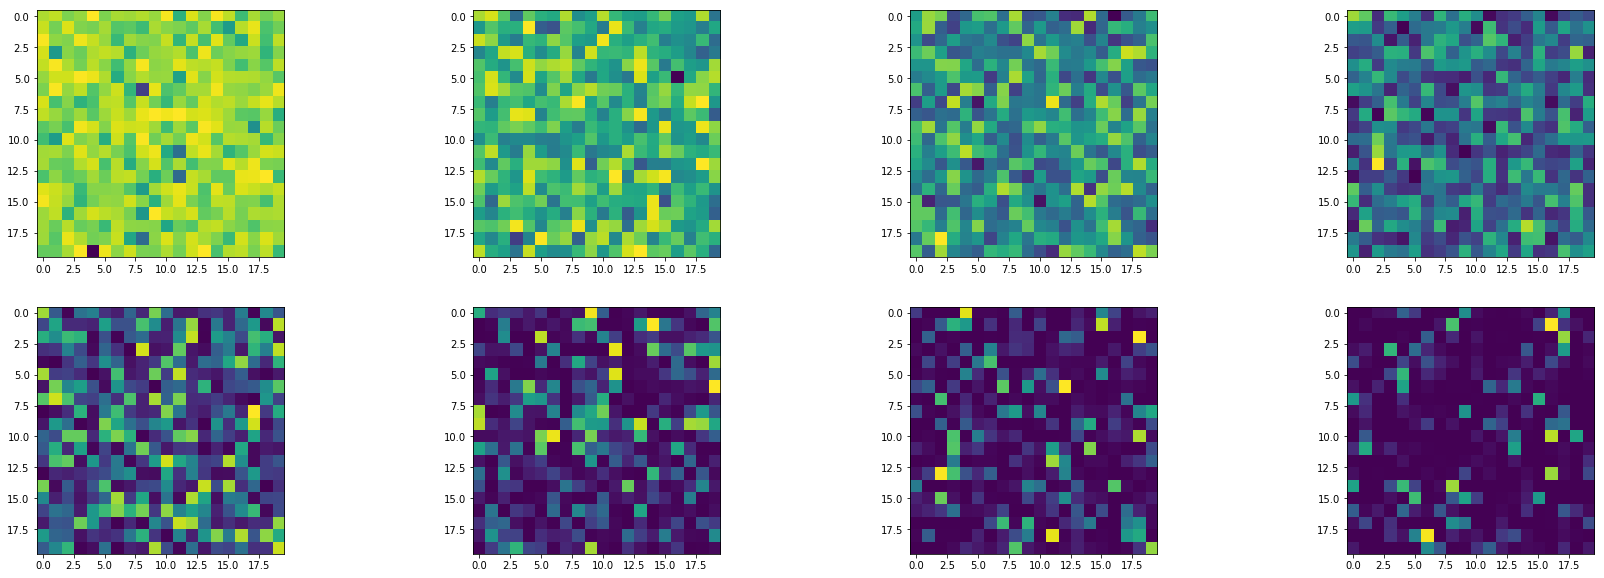

In [116]:
fig = plt.figure(figsize=(30, 10))
for i in range(8):
    fi = c2[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(fi.reshape(20,20))
plt.show()

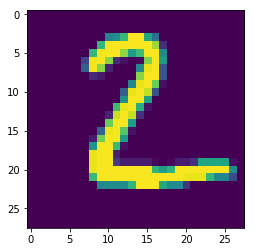

In [117]:
img,label = test_dataset[1]
plt.imshow(img.view(28,28))

In [118]:
img = img.view(1,1,28,28).to(device)

s1, c1, s2, c2 = model.get_all_layers(img)

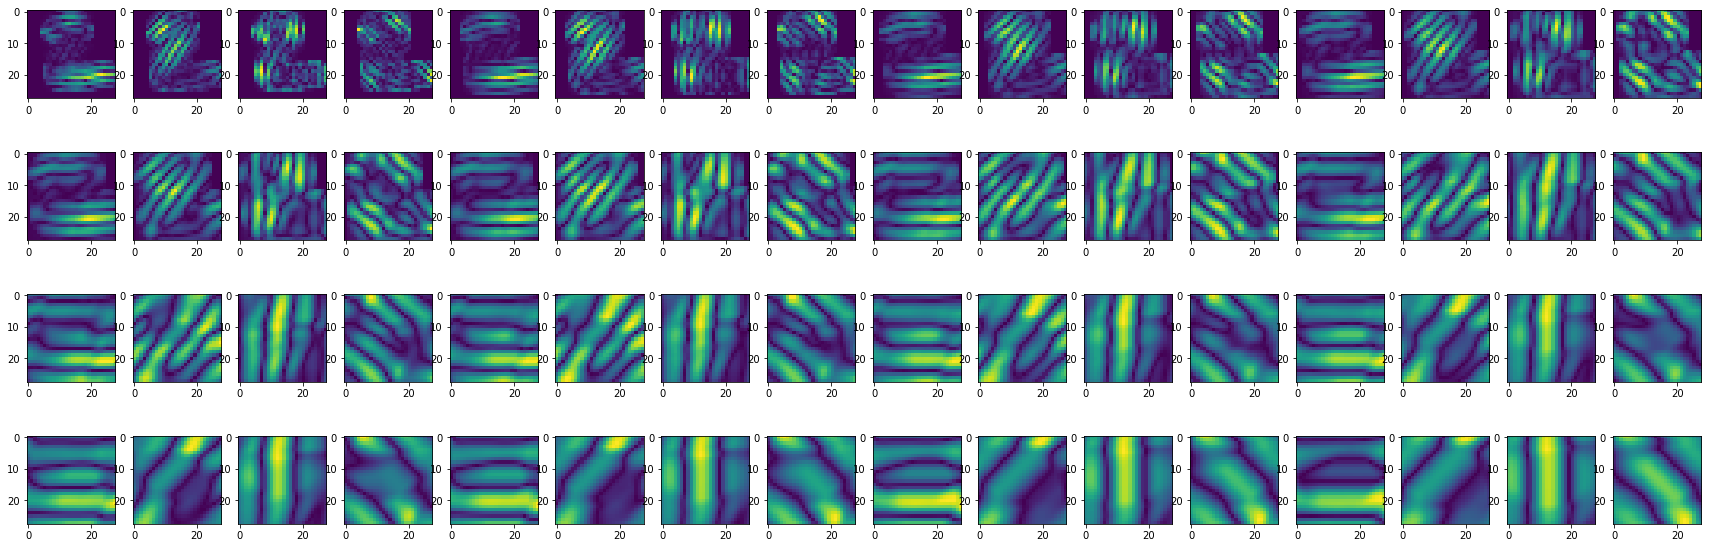

In [121]:
fig = plt.figure(figsize=(30, 10))
for i in range(16):
    for j in range(4):
        si = s1[i][0,j,:,:]
        ax = fig.add_subplot(4,16,i*4+j+1)
        ax.imshow(si.reshape(28,28))
plt.savefig("3.jpg")
plt.show()

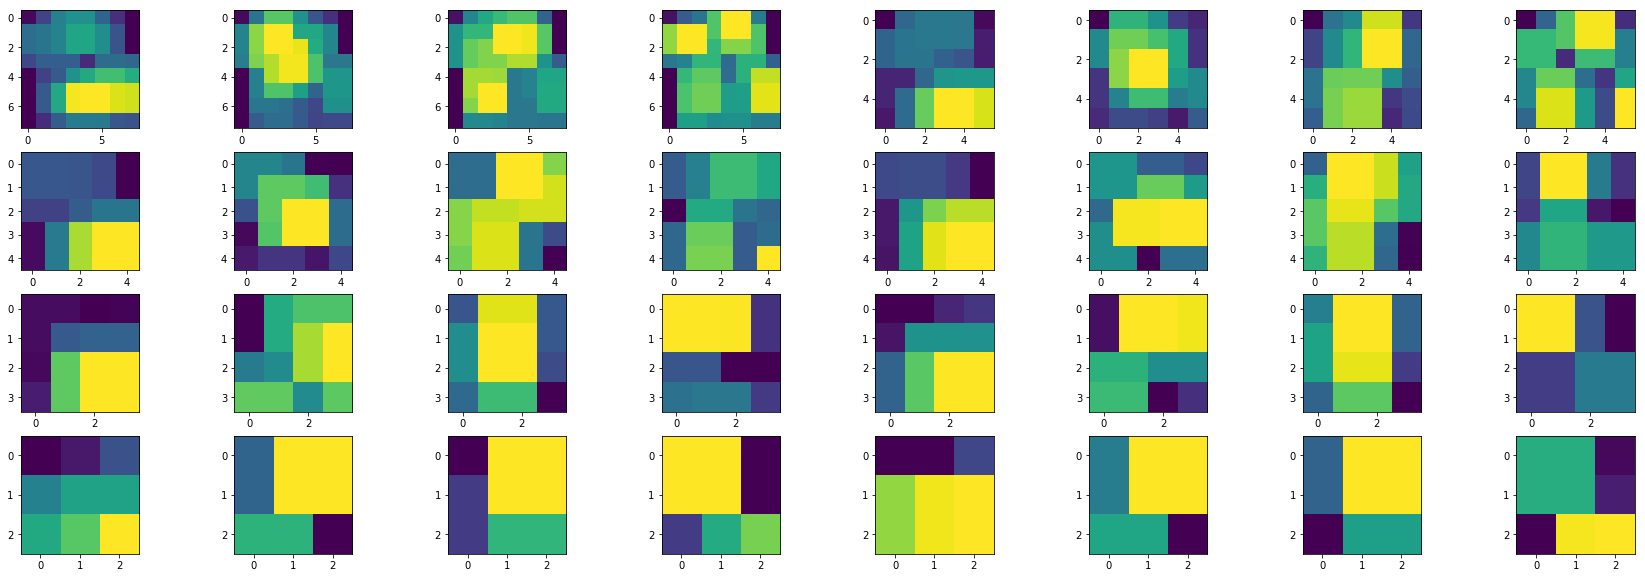

In [122]:
fig = plt.figure(figsize=(30, 10))
for i in range(8):
    for j in range(4):
        ci = c1[i][0,j,:,:]
        ax = fig.add_subplot(4,8,i*4+j+1)
        ax.imshow(ci)
plt.savefig("4.jpg")
plt.show()

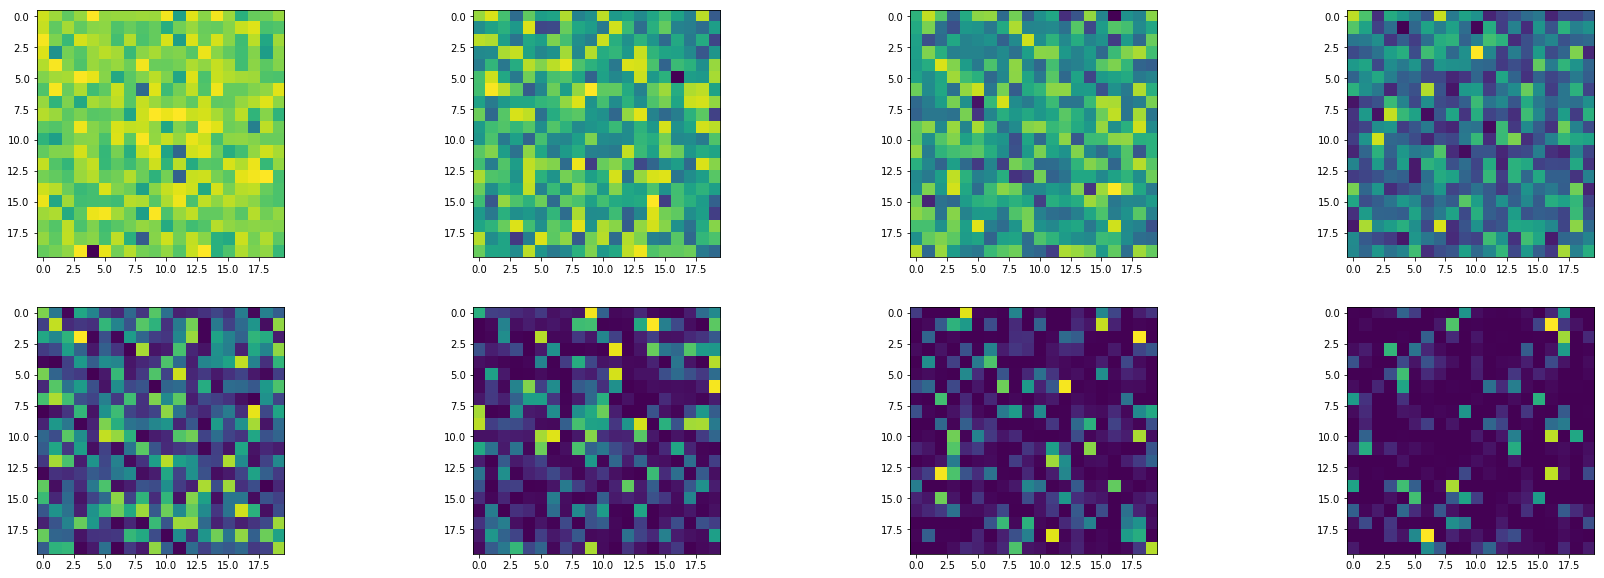

In [123]:
fig = plt.figure(figsize=(30, 10))
for i in range(8):
    fi = c2[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(fi.reshape(20,20))
plt.show()